In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math as math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Input, LSTM, GRU, Dropout
from keras.models import Model
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import parallel_backend
from time import time
from tensorflow.keras.callbacks import TensorBoard
import warnings
from prettytable import PrettyTable
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_fwf('SPX.txt', names=['date', 'value'])
volatility = pd.read_fwf('VIX.txt', names=['date', 'value'])

In [3]:
file_name = 'mobnet2'
tensorboard = TensorBoard(log_dir="logs2/{}".format(file_name))

In [4]:
X = np.array(data['value'])
X = X.reshape((1292, 1))

training_data_len = math.ceil(len(X)* 0.75) # training set has 75% of the data
training_data_len

# Normalizing data before model fitting using MinMaxScaler
# Feature Scaling

sc = MinMaxScaler(feature_range=(0,1))
training_data = sc.fit_transform(X)
training_data

array([[0.        ],
       [0.00206228],
       [0.00159837],
       ...,
       [0.98682323],
       [0.97501092],
       [0.97122942]])

In [49]:
split_val = 887
train_data = training_data[0:split_val  , : ]

X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i-180:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train) # converting into numpy sequences to train the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print('Number of rows and columns: ', X_train.shape)  #(887 values, 180 time-steps, 1 output)


Number of rows and columns:  (707, 180, 1)


In [6]:
test_data = training_data[split_val - 180: , : ]

# Create the x_test and y_test data sets
X_test = []
y_test =  X[split_val : , : ]
for i in range(180,len(test_data)):
    X_test.append(test_data[i-180:i,0])

# Convert x_test to a numpy array
X_test = np.array(X_test)

#Reshape the data into the shape accepted by the LSTM
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print('Number of rows and columns: ', X_test.shape)


Number of rows and columns:  (405, 180, 1)


# LSTM

$$i_t = \sigma(W_{ix} x_t + W_{ih} h_{t-1} + b_i)$$

$$f_t = \sigma(W_{fx} x_t + W_{fh} h_{t-1} + b_f)$$

$$C_t = f_t \odot C_{t}$$

In [7]:
model_LSTM = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_LSTM.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = 50, return_sequences = True))
model_LSTM.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_LSTM.add(LSTM(units = 50, return_sequences = True))
model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units = 50))
model_LSTM.add(Dropout(0.3))

# Adding the output layer
model_LSTM.add(Dense(units = 1))

# Compiling the LSTM
model_LSTM.compile(
    optimizer = 'adam', 
    loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model_LSTM.fit(X_train, y_train, epochs = 100, batch_size = 32, callbacks=[tensorboard])


Epoch 1/100
23/23 [==============================] - 17s 438ms/step - loss: 0.0162
Epoch 2/100
23/23 [==============================] - 8s 328ms/step - loss: 0.0039
Epoch 3/100
23/23 [==============================] - 8s 325ms/step - loss: 0.0031
Epoch 4/100
23/23 [==============================] - 7s 325ms/step - loss: 0.0027
Epoch 5/100
23/23 [==============================] - 7s 321ms/step - loss: 0.0026
Epoch 6/100
23/23 [==============================] - 8s 325ms/step - loss: 0.0025
Epoch 7/100
23/23 [==============================] - 7s 321ms/step - loss: 0.0025
Epoch 8/100
23/23 [==============================] - 8s 333ms/step - loss: 0.0022
Epoch 9/100
23/23 [==============================] - 8s 323ms/step - loss: 0.0023
Epoch 10/100
23/23 [==============================] - 8s 327ms/step - loss: 0.0020
Epoch 11/100
23/23 [==============================] - 8s 326ms/step - loss: 0.0019
Epoch 12/100
23/23 [==============================] - 7s 322ms/step - loss: 0.0019
Epoch 13/100

23/23 [==============================] - 8s 329ms/step - loss: 5.2809e-04
Epoch 98/100
23/23 [==============================] - 8s 327ms/step - loss: 5.0094e-04
Epoch 99/100
23/23 [==============================] - 8s 322ms/step - loss: 4.9408e-04
Epoch 100/100
23/23 [==============================] - 8s 335ms/step - loss: 5.1479e-04


In [50]:
lstm_pred = model_LSTM.predict(X_test)
lstm_pred = sc.inverse_transform(lstm_pred)
train = data[:split_val]
valid = data[split_val:]
valid['Predictions'] = lstm_pred

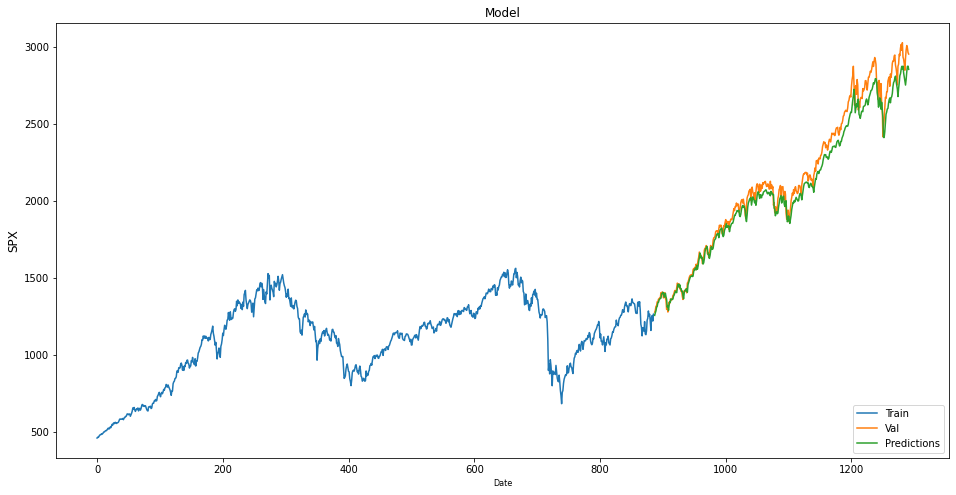

0.9413295479309945

In [51]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(train_['value'])
plt.plot(valid_[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
score = r2_score(y_test, lstm_pred)
score

# CNN-LSTM


$$a^{(l)}_{i,j} = \sum_{m=0}^{F-1} \sum_{n=0}^{F-1} W^{(l)}_{m,n} \cdot a^{(l-1)}_{i+m, j+n} + b^{(l)}$$

$$a^{(l)}_{i,j} =  \max_{m=0}^{F-1} \max_{n=0}^{F-1} a^{(l)}_{i \times S+m, j \times S+n}$$

$$y = \sigma(W \cdot a^{(l)} + b)$$

In [10]:
# Define the input layer
inputs = Input(shape=(X_train.shape[1], 1))

# Add a 1D convolutional layer
x = Conv1D(filters=64, kernel_size=2, activation='relu')(inputs)
# Add an LSTM layer
x = LSTM(32)(x)
# Add a dense output layer
outputs = Dense(1)(x)
# Define the model
CNN_LSTM = Model(inputs, outputs)
# Compile the model
CNN_LSTM.compile(optimizer='adam', loss='mean_squared_error')

# train the model on the training data
CNN_LSTM.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)


Epoch 1/100
23/23 [==============================] - 5s 117ms/step - loss: 0.0157 - val_loss: 4742740.5000
Epoch 2/100
23/23 [==============================] - 2s 87ms/step - loss: 0.0017 - val_loss: 4742400.5000
Epoch 3/100
23/23 [==============================] - 2s 89ms/step - loss: 9.2798e-04 - val_loss: 4742318.0000
Epoch 4/100
23/23 [==============================] - 2s 88ms/step - loss: 7.3949e-04 - val_loss: 4742231.0000
Epoch 5/100
23/23 [==============================] - 2s 88ms/step - loss: 6.2294e-04 - val_loss: 4742125.5000
Epoch 6/100
23/23 [==============================] - 2s 91ms/step - loss: 5.3560e-04 - val_loss: 4742039.5000
Epoch 7/100
23/23 [==============================] - 2s 89ms/step - loss: 4.8285e-04 - val_loss: 4741921.5000
Epoch 8/100
23/23 [==============================] - 2s 88ms/step - loss: 4.4724e-04 - val_loss: 4741914.5000
Epoch 9/100
23/23 [==============================] - 2s 89ms/step - loss: 4.3356e-04 - val_loss: 4741856.5000
Epoch 10/100
23/2

Epoch 75/100
23/23 [==============================] - 2s 82ms/step - loss: 1.6903e-04 - val_loss: 4742029.5000
Epoch 76/100
23/23 [==============================] - 2s 81ms/step - loss: 1.8052e-04 - val_loss: 4741903.0000
Epoch 77/100
23/23 [==============================] - 2s 82ms/step - loss: 1.8934e-04 - val_loss: 4742004.5000
Epoch 78/100
23/23 [==============================] - 2s 81ms/step - loss: 1.8026e-04 - val_loss: 4741960.0000
Epoch 79/100
23/23 [==============================] - 2s 81ms/step - loss: 1.7152e-04 - val_loss: 4741902.5000
Epoch 80/100
23/23 [==============================] - 2s 82ms/step - loss: 1.9885e-04 - val_loss: 4742012.5000
Epoch 81/100
23/23 [==============================] - 2s 81ms/step - loss: 1.6885e-04 - val_loss: 4741970.5000
Epoch 82/100
23/23 [==============================] - 2s 79ms/step - loss: 1.6559e-04 - val_loss: 4741930.5000
Epoch 83/100
23/23 [==============================] - 2s 80ms/step - loss: 1.7667e-04 - val_loss: 4741984.5000
E

In [12]:
CNN_LSTM_pred = CNN_LSTM.predict(X_test)
CNN_LSTM_pred = sc.inverse_transform(CNN_LSTM_pred)
train_ = data[:split_val]
valid_ = data[split_val:]
valid_['Predictions'] = CNN_LSTM_pred
score = r2_score(y_test, CNN_LSTM_pred)
score

0.9720297063012733

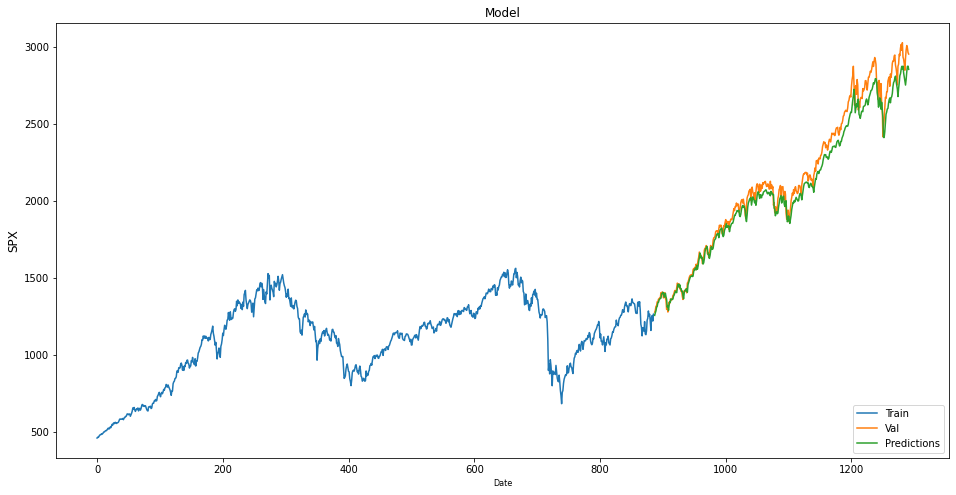

In [13]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(train_['value'])
plt.plot(valid_[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


# GRU 

$$z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)$$

$$r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)$$

$$h'_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h)$$


In [14]:
model_GRU = Sequential()

#Adding the first GRU layer and some Dropout regularisation
model_GRU.add(LSTM(units = 200, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_GRU.add(Dropout(0.2))

# Adding a second GRU layer and some Dropout regularisation
model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences = True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50, return_sequences=True))
model_GRU.add(Dropout(0.2))

model_GRU.add(GRU(units = 50))
model_GRU.add(Dropout(0.2))

# Adding the output layer
model_GRU.add(Dense(units = 1))

# Compiling the network
model_GRU.compile(
    optimizer = 'adam', 
    loss = 'mean_squared_error')

# Fitting the network to the Training set
model_GRU.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
23/23 [==============================] - 27s 733ms/step - loss: 0.0152
Epoch 2/100
23/23 [==============================] - 17s 757ms/step - loss: 0.0046
Epoch 3/100
23/23 [==============================] - 17s 748ms/step - loss: 0.0034
Epoch 4/100
23/23 [==============================] - 17s 740ms/step - loss: 0.0025
Epoch 5/100
23/23 [==============================] - 17s 745ms/step - loss: 0.0016
Epoch 6/100
23/23 [==============================] - 17s 746ms/step - loss: 0.0017
Epoch 7/100
23/23 [==============================] - 17s 749ms/step - loss: 0.0018
Epoch 8/100
23/23 [==============================] - 17s 736ms/step - loss: 0.0017
Epoch 9/100
23/23 [==============================] - 17s 758ms/step - loss: 0.0015
Epoch 10/100
23/23 [==============================] - 17s 744ms/step - loss: 0.0013
Epoch 11/100
23/23 [==============================] - 17s 741ms/step - loss: 0.0014
Epoch 12/100
23/23 [==============================] - 17s 728ms/step - loss: 0.0014
E

23/23 [==============================] - 18s 778ms/step - loss: 4.5412e-04
Epoch 96/100
23/23 [==============================] - 18s 761ms/step - loss: 4.4830e-04
Epoch 97/100
23/23 [==============================] - 17s 755ms/step - loss: 4.6144e-04
Epoch 98/100
23/23 [==============================] - 18s 771ms/step - loss: 4.4813e-04
Epoch 99/100
23/23 [==============================] - 17s 754ms/step - loss: 4.1403e-04
Epoch 100/100
23/23 [==============================] - 17s 760ms/step - loss: 4.3102e-04


In [15]:
model_GRU_pred = model_GRU.predict(X_test)
model_GRU_pred = sc.inverse_transform(model_GRU_pred)
train = data[:split_val]
valid = data[split_val:]
valid['Predictions'] = model_GRU_pred
score = r2_score(y_test, model_GRU_pred)
score

0.9582086109302973

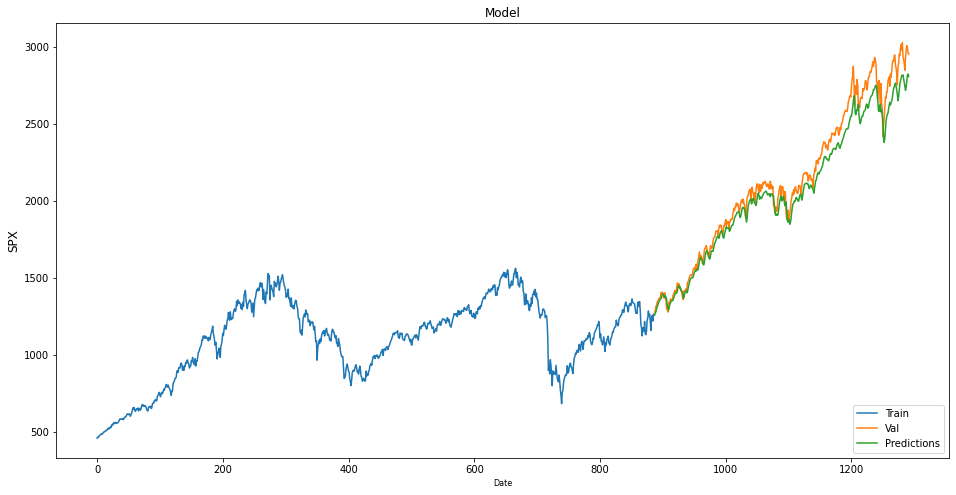

In [16]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [17]:
# Parameters
input_shape = (X_train.shape[1], 1)

# Build the model
CNN = Sequential()
CNN.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
CNN.add(MaxPooling1D(pool_size=2))
#CNN.add(LSTM(units=50, return_sequences=True))
CNN.add(Dropout(0.2))
CNN.add(Flatten())
CNN.add(Dense(1, activation='relu'))

# Compile the model
CNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
CNN.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32)

Epoch 1/100
23/23 [==============================] - 1s 28ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - val_loss: 4742353.5000 - val_accuracy: 0.0000e+00
Epoch 2/100
23/23 [==============================] - 0s 21ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - val_loss: 4742439.0000 - val_accuracy: 0.0000e+00
Epoch 3/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0017 - accuracy: 0.0000e+00 - val_loss: 4742601.0000 - val_accuracy: 0.0000e+00
Epoch 4/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0014 - accuracy: 0.0000e+00 - val_loss: 4742505.0000 - val_accuracy: 0.0000e+00
Epoch 5/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0012 - accuracy: 0.0000e+00 - val_loss: 4742390.0000 - val_accuracy: 0.0000e+00
Epoch 6/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 4742337.5000 - val_accuracy: 0.0000e+00
Epoch 7/100
23/23 [==============================] - 0s 21ms/ste

23/23 [==============================] - 0s 18ms/step - loss: 4.7223e-04 - accuracy: 0.0000e+00 - val_loss: 4742030.0000 - val_accuracy: 0.0000e+00
Epoch 53/100
23/23 [==============================] - 0s 18ms/step - loss: 6.0010e-04 - accuracy: 0.0000e+00 - val_loss: 4742062.0000 - val_accuracy: 0.0000e+00
Epoch 54/100
23/23 [==============================] - 0s 20ms/step - loss: 5.5275e-04 - accuracy: 0.0000e+00 - val_loss: 4741915.0000 - val_accuracy: 0.0000e+00
Epoch 55/100
23/23 [==============================] - 0s 18ms/step - loss: 3.7429e-04 - accuracy: 0.0000e+00 - val_loss: 4741924.5000 - val_accuracy: 0.0000e+00
Epoch 56/100
23/23 [==============================] - 1s 23ms/step - loss: 3.9923e-04 - accuracy: 0.0000e+00 - val_loss: 4741840.5000 - val_accuracy: 0.0000e+00
Epoch 57/100
23/23 [==============================] - 0s 20ms/step - loss: 4.0382e-04 - accuracy: 0.0000e+00 - val_loss: 4741910.5000 - val_accuracy: 0.0000e+00
Epoch 58/100
23/23 [===========================

In [18]:
CNN_pred = CNN.predict(X_test)
CNN_pred = sc.inverse_transform(CNN_pred)
train = data[:split_val]
valid = data[split_val:]
valid['Predictions'] = CNN_pred
score = r2_score(y_test, CNN_pred)
score

0.977622916997536

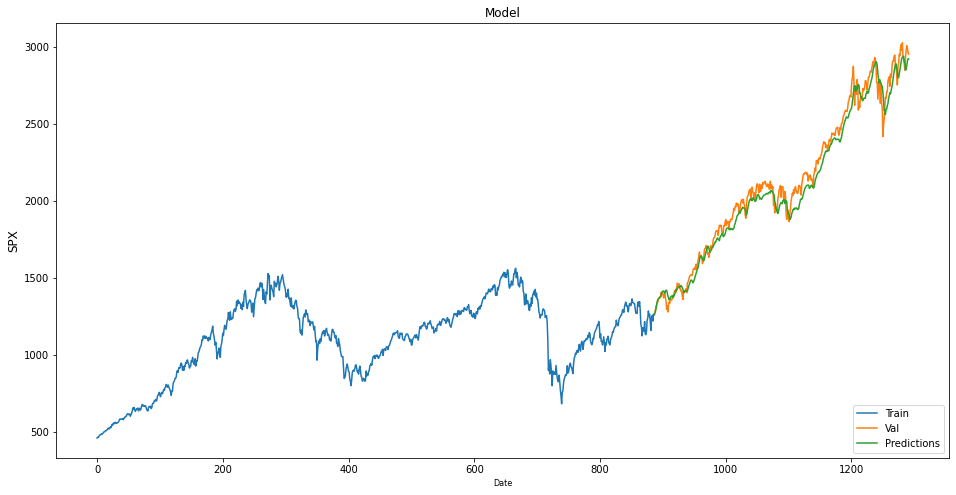

In [19]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=8)
plt.ylabel('SPX', fontsize=12)
plt.plot(train['value'])
plt.plot(valid[['value', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


In [20]:
# Pour savoir si le modèle prédit une hausse ou une baisse j'ai choisi d'utilisé la différence première 
# On prenant soin de coder les baisses en 0 et les hausses en 1 
# Avec cette méthode il suiffit de calculer la distance de Hamming pour savoir combien de fois le modèle ne prédit pas 
# Si la série en hausse ou en baisse les résultats sont résumés dans le tableau final
def compute_return(time_series):
    returns = []
    for i in range(1, len(time_series)):
        returns.append((time_series[i] - time_series[i-1]) / time_series[i-1])
    for i in range(len(returns)):
        if returns[i] >= 0:
            returns[i] = 1
        else:
            returns[i] = 0
    return returns

In [22]:
true_data = compute_return(y_test)
lstm_moves = compute_return(lstm_pred)
cnn_lstm_moves = compute_return(CNN_LSTM_pred)
gru_moves = compute_return(model_GRU_pred)
cnn_moves = compute_return(CNN_pred)

In [23]:
def hamming_distance(list1, list2):
    distance = 0
    for i in range(len(list1)):
        if list1[i] != list2[i]:
            distance += 1
    return distance

In [47]:
x = PrettyTable()
x.field_names = ["", "Accuracy", "MSE", "MAE", "Hamming distance"]

x.add_row(["LSTM", 
           str(round(r2_score(y_test, lstm_pred),2)), 
           str(round(mean_squared_error(y_test, lstm_pred),2)), 
           str(round(mean_absolute_error(y_test, lstm_pred),2)),
           str(hamming_distance(true_data, lstm_moves))
          ]
         )
x.add_row(["CNN-LSTM", 
           str(round(r2_score(y_test, CNN_LSTM_pred),2)), 
           str(round(mean_squared_error(y_test, CNN_LSTM_pred),2)), 
           str(round(mean_absolute_error(y_test, CNN_LSTM_pred),2)),
           str(hamming_distance(true_data, cnn_lstm_moves))
          ]
         )
x.add_row(["GRU", 
           tr(round(r2_score(y_test, model_GRU_pred),2)), 
           str(round(mean_squared_error(y_test, model_GRU_pred),2)), 
           str(round(mean_absolute_error(y_test, model_GRU_pred),2)),
           str(hamming_distance(true_data, gru_moves))
          ]
         )
           
x.add_row(["CNN", 
           str(round(r2_score(y_test, CNN_pred),2)), 
           str(round(mean_squared_error(y_test, CNN_pred),2)), 
           str(round(mean_absolute_error(y_test, CNN_pred),2)),
           str(hamming_distance(true_data, cnn_moves))
          ]
         )
print(x)

+----------+----------+----------+-------+------------------+
|          | Accuracy |   MSE    |  MAE  | Hamming distance |
+----------+----------+----------+-------+------------------+
|   LSTM   |   0.94   | 13547.65 | 99.93 |       196        |
| CNN-LSTM |   0.97   | 6458.65  | 64.69 |       201        |
|   GRU    |   0.96   | 9650.09  | 79.17 |       199        |
|   CNN    |   0.98   | 5167.11  | 59.49 |       201        |
+----------+----------+----------+-------+------------------+


D'après le tableau des résultats l'architecture CNN arrive à achever un score qui est sup au LSTM et GRU qui sont supposés etre spécialisé dans le donées séquentielles par contntre sur le niveau de la ditance Hamming qui ici refaire à la capacité du modèle à prédire le sens du mouvement de la série (up & down) on retrouve bine l'architecture LSTM et GRU en haut des résultats.